### **Análisis del conjunto de datos**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# 1. Cargar el archivo CSV
pd.set_option('display.width', 1000)
dataframe = pd.read_csv('anemia.csv')
print("Datos iniciales:")
print(dataframe.head())  # Muestra los primeros registros para una vista rápida de cómo están estructurados los datos.

In [ ]:
# 2. Exploración inicial del conjunto de datos
print("\nInformación general del conjunto de datos:")
print(dataframe.info())  # Muestra información general del conjunto de datos.

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
# Eliminar las columnas 'gender' y 'result' del DataFrame antes de describirlo
dataframe_sin_columnas = dataframe.drop(columns=['Gender', 'Result'])
print(dataframe_sin_columnas.describe())  # Muestra estadísticas descriptivas de las columnas numéricas.

# Contar el número de hombres y mujeres
print("\nCantidad de hombres y mujeres:")
gender_counts = dataframe['Gender'].value_counts()
print(gender_counts)

# Valores únicos por columna para identificar posibles problemas
print("\nValores únicos por columna:")
print(dataframe.nunique())  # Muestra la cantidad de valores únicos por columna.

# 3. Revisión y manejo de valores nulos
print("\nValores nulos por columna:")
print(dataframe.isnull().sum())  # Muestra la cantidad de valores nulos por columna.

In [ ]:
# 4. Exploración detallada de características
print("\nVisualización de distribuciones individuales de las características:")
for column in dataframe.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(dataframe[column].dropna(), kde=True, bins=20)  # Un histograma con KDE para visualizar la forma de la distribución.
    plt.title(f'Distribución de {column}')
    plt.xlim(0, dataframe[column].max() * 1.1)  # Ajustar límites del eje X para ver mejor la distribución completa.
    plt.show()

# Mapa de calor de correlación entre variables
# Visualizamos la correlación entre las variables para detectar relaciones importantes entre las características.
plt.figure(figsize=(8, 6))
sns.heatmap(dataframe.corr(), annot=True, cmap='coolwarm', linewidths=0.5)  # Se destaca con anotaciones el valor de la correlación.
plt.title('Mapa de calor de correlación entre variables')
plt.show()


print("\nExploración de relaciones entre variables:")
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Hemoglobin', y='MCV', hue='Result', data=dataframe)  # Un scatter plot para explorar la relación entre dos variables clave.
plt.title('Relación entre Hemoglobin y MCV, coloreada por Result')
plt.show()

# Pares de variables para explorar relaciones adicionales
sns.pairplot(dataframe, hue='Result', vars=['Gender', 'Hemoglobin', 'MCH', 'MCHC', 'MCV'])  # Utilizamos pairplots para analizar múltiples relaciones.
plt.show()

# Justificación adicional: las relaciones entre vaiables como 'Hemoglobin' y 'MCV' pueden ser útiles para predecir tipos de anemia.

In [ ]:
# 5. Evaluación del balance de clases
print("\nDistribución de clases (0: No tiene anemia, 1: Tiene anemia):")
sns.countplot(x='Result', data=dataframe)
plt.title('Distribución de clases')
plt.show()

# Mostrar el porcentaje de cada clase.
print("\nDistribución de clases en porcentaje:")
print(dataframe['Result'].value_counts(normalize=True) * 100)

In [ ]:
# 6. Detección de outliers usando diagramas de caja
# Seleccionamos las columnas relevantes para detectar outliers.
columnas_relevantes = ['Gender', 'Hemoglobin', 'MCH', 'MCHC', 'MCV']
for column in columnas_relevantes:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=dataframe[column])  # Un boxplot para visualizar outliers basados en el IQR.
    plt.title(f'Diagrama de caja de {column}')
    plt.show()

    # Detección de outliers utilizando el rango intercuartílico (IQR)
    # Calculamos los valores atípicos con el IQR (Interquartile Range) para cada columna relevante.
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = dataframe[(dataframe[column] < (Q1 - 1.5 * IQR)) | (dataframe[column] > (Q3 + 1.5 * IQR))]
    porcentaje_outliers = (len(outliers) / len(dataframe)) * 100
    print(f"Outliers detectados en {column}: {len(outliers)} ({porcentaje_outliers:.2f}% del total)")

### **Modelo y evaluación**

In [ ]:
# 8. Separación de datos para entrenamiento, validación y prueba
X = dataframe.drop('Result', axis=1)  # Características
Y = dataframe['Result']  # Etiquetas

# División de datos en entrenamiento, validación y prueba
# Se utiliza una proporción de 70% para entrenamiento, 15% para validación y 15% para prueba.
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.30, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.50, random_state=42, stratify=Y_temp)

# Prueba de Shapiro-Wilk para saber si los datos siguen una distribución normal.
# Si es una distribución normal, se utilizará StandardScaler
# Si no es una distribución normal, por la naturaleza de los datos y la futura implementación de KNN se utilizará MinMaxScaler
print("\nPrueba de Shapiro-Wilk para cada columna:")

# Verificar normalidad para cada columna y decidir el tipo de escalador
usar_minmax_scaler = False
for columna in X.columns:
    stat, p = shapiro(dataframe[columna])
    print(f'Estadístico de Shapiro-Wilk para {columna}: {stat:.4f}, p-valor: {p:.4f}')
    if p < 0.05:
        print(f'Los datos de {columna} no siguen una distribución normal (se rechaza H0)')
        usar_minmax_scaler = True
    else:
        print(f'Los datos de {columna} parecen seguir una distribución normal (no se rechaza H0)')

# Decisión sobre el escalador a utilizar
if usar_minmax_scaler:
    print("\nSe utilizará MinMaxScaler debido a la falta de normalidad en una o más columnas.")
    scaler = MinMaxScaler()
else:
    print("\nSe utilizará StandardScaler ya que los datos siguen una distribución normal.")
    scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# 9. Sobremuestreo usando SMOTE
# El dataset tiene un desbalance de clases no tan grande (aproximadamente 56% no anémicos, 44% anémicos).
# De igual forma esto puede afectar el desempeño de los modelos, especialmente en la capacidad de detectar correctamente 
# los casos positivos (recall). Utilizamos SMOTE para generar ejemplos sintéticos de la clase minoritaria, sin necesidad de eliminar datos. 
# También aplicamos ajuste de pesos en la regresión logística para mejorar la sensibilidad a la clase minoritaria.

smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X_train, Y_train)

# Verificación del nuevo balance de clases después de aplicar SMOTE
# Nos aseguramos de que las clases estén balanceadas al 50/50 en el conjunto de entrenamiento después de SMOTE.
print("\nDistribución de clases después de aplicar SMOTE en los datos de entrenamiento:")
print(pd.Series(Y_resampled).value_counts(normalize=True) * 100)

# Visualización de las distribuciones antes y después de SMOTE
# Justificación: Verificamos las distribuciones de las columnas antes y después de SMOTE para asegurarnos de que no se alteraron significativamente.

print("\nDistribuciones antes de SMOTE (normalizadas):")
for column in range(X_train_scaled.shape[1]):
    plt.figure(figsize=(6, 4))
    sns.histplot(X_train_scaled[:, column], kde=True, bins=20, label='Antes de SMOTE')
    plt.title(f'Distribución de columna {X.columns[column]} antes de SMOTE')
    plt.legend()
    plt.show()

print("\nDistribuciones después de SMOTE (normalizadas):")
for column in range(X_resampled.shape[1]):
    plt.figure(figsize=(6, 4))
    sns.histplot(X_resampled.iloc[:, column], kde=True, bins=20, label='Después de SMOTE', color='orange')
    plt.title(f'Distribución de columna {X.columns[column]} después de SMOTE')
    plt.legend()
    plt.show()

In [ ]:
# 10.1 Entrenamiento de Modelo de Regresión Logística
# Aplicamos class_weight='balanced' para ajustar los pesos de las clases, mejorando el rendimiento en la clase minoritaria.
print("\nEntrenando el modelo de Regresión Logística...")
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_resampled, Y_resampled)

# Verificación del modelo con el conjunto de validación
# Justificación: Validamos el modelo con el conjunto de validación para obtener métricas como accuracy, precision, recall, F1-score y AUC-ROC.
Y_val_pred_logreg = log_reg.predict(X_val)
Y_val_prob_logreg = log_reg.predict_proba(X_val)[:, 1]

# Evaluación del modelo de Regresión Logística en validación
print("\nResultados del modelo de Regresión Logística (Validación):")
print(f"Accuracy: {accuracy_score(Y_val, Y_val_pred_logreg):.4f}")
print(f"Precision: {precision_score(Y_val, Y_val_pred_logreg):.4f}")
print(f"Recall: {recall_score(Y_val, Y_val_pred_logreg):.4f}")
# Calculamos F1-Score para balancear precision y recall
f1_val_logreg = f1_score(Y_val, Y_val_pred_logreg)
print(f"F1-Score: {f1_val_logreg:.4f}")
# AUC-ROC para medir la capacidad del modelo para distinguir entre clases
auc_roc_val_logreg = roc_auc_score(Y_val, Y_val_prob_logreg)
print(f"AUC-ROC: {auc_roc_val_logreg:.4f}")

# Mostramos la matriz de confusión para la validación
cm_logreg = confusion_matrix(Y_val, Y_val_pred_logreg)
ConfusionMatrixDisplay(cm_logreg).plot(cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística (Validación)")
plt.show()

# Evaluación en el conjunto de prueba
# Justificación: Evaluamos el rendimiento final del modelo en el conjunto de prueba, que no ha sido utilizado en el entrenamiento o validación.
Y_test_pred_logreg = log_reg.predict(X_test)
Y_test_prob_logreg = log_reg.predict_proba(X_test)[:, 1]

print("\nResultados del modelo de Regresión Logística (Prueba):")
print(f"Accuracy: {accuracy_score(Y_test, Y_test_pred_logreg):.4f}")
print(f"Precision: {precision_score(Y_test, Y_test_pred_logreg):.4f}")
print(f"Recall: {recall_score(Y_test, Y_test_pred_logreg):.4f}")
# Calculamos F1-Score y AUC-ROC para el conjunto de prueba
f1_test_logreg = f1_score(Y_test, Y_test_pred_logreg)
print(f"F1-Score: {f1_test_logreg:.4f}")
auc_roc_test_logreg = roc_auc_score(Y_test, Y_test_prob_logreg)
print(f"AUC-ROC: {auc_roc_test_logreg:.4f}")

# Mostramos la matriz de confusión para el conjunto de prueba
cm_test_logreg = confusion_matrix(Y_test, Y_test_pred_logreg)
ConfusionMatrixDisplay(cm_test_logreg).plot(cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística (Prueba)")
plt.show()


Entrenando el modelo de Regresión Logística con hiperparámetros de más...

Resultados de validación para cada combinación de hiperparámetros:
                                             params  accuracy  precision  recall       f1  auc_roc
{'solver': 'liblinear', 'C': 0.01, 'penalty': 'l1'}  0.976526    0.94898     1.0 0.973822 0.944444
{'solver': 'liblinear', 'C': 0.01, 'penalty': 'l2'}  0.976526    0.94898     1.0 0.973822 0.967742
 {'solver': 'liblinear', 'C': 0.1, 'penalty': 'l1'}  0.976526    0.94898     1.0 0.973822 0.993280
 {'solver': 'liblinear', 'C': 0.1, 'penalty': 'l2'}  0.976526    0.94898     1.0 0.973822 0.989247
   {'solver': 'liblinear', 'C': 1, 'penalty': 'l1'}  0.976526    0.94898     1.0 0.973822 1.000000
   {'solver': 'liblinear', 'C': 1, 'penalty': 'l2'}  0.976526    0.94898     1.0 0.973822 0.995161
{'solver': 'newton-cg', 'C': 0.01, 'penalty': 'l2'}  0.976526    0.94898     1.0 0.973822 0.984588
 {'solver': 'newton-cg', 'C': 0.1, 'penalty': 'l2'}  0.976526    

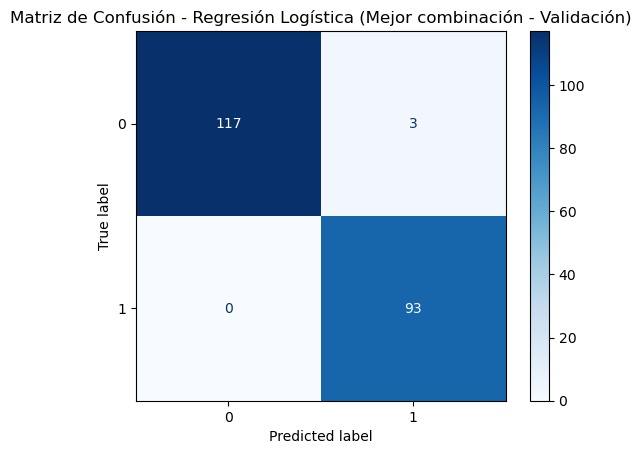


Resultados de prueba para cada combinación de hiperparámetros:
                                             params  accuracy  precision   recall       f1  auc_roc
{'solver': 'liblinear', 'C': 0.01, 'penalty': 'l1'}  0.864486   0.840426 0.849462 0.844920 0.951657
{'solver': 'liblinear', 'C': 0.01, 'penalty': 'l2'}  0.878505   0.852632 0.870968 0.861702 0.968009
 {'solver': 'liblinear', 'C': 0.1, 'penalty': 'l1'}  0.915888   0.894737 0.913978 0.904255 0.984449
 {'solver': 'liblinear', 'C': 0.1, 'penalty': 'l2'}  0.906542   0.884211 0.903226 0.893617 0.980894
   {'solver': 'liblinear', 'C': 1, 'penalty': 'l1'}  0.971963   0.948454 0.989247 0.968421 0.998134
   {'solver': 'liblinear', 'C': 1, 'penalty': 'l2'}  0.925234   0.905263 0.924731 0.914894 0.987470
{'solver': 'newton-cg', 'C': 0.01, 'penalty': 'l2'}  0.939252   0.900000 0.967742 0.932642 0.984449
 {'solver': 'newton-cg', 'C': 0.1, 'penalty': 'l2'}  0.962617   0.920792 1.000000 0.958763 0.996001
   {'solver': 'newton-cg', 'C': 1, '

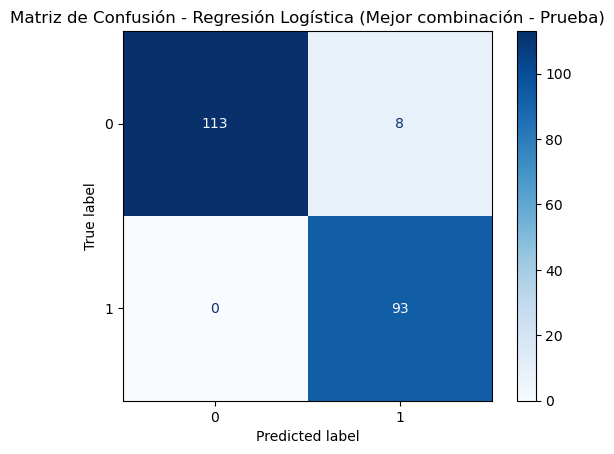

In [181]:
# 10.1.1 Entrenamiento de Modelo de Regresión Logística con hiperparámetros de más 
import warnings
from sklearn.exceptions import ConvergenceWarning
print("\nEntrenando el modelo de Regresión Logística con hiperparámetros de más...")

# Definir las combinaciones de hiperparámetros a evaluar
param_combinations = [
    {'solver': 'liblinear', 'C': 0.01, 'penalty': 'l1'},
    {'solver': 'liblinear', 'C': 0.01, 'penalty': 'l2'},
    {'solver': 'liblinear', 'C': 0.1, 'penalty': 'l1'},
    {'solver': 'liblinear', 'C': 0.1, 'penalty': 'l2'},
    {'solver': 'liblinear', 'C': 1, 'penalty': 'l1'},
    {'solver': 'liblinear', 'C': 1, 'penalty': 'l2'},
    {'solver': 'newton-cg', 'C': 0.01, 'penalty': 'l2'},
    {'solver': 'newton-cg', 'C': 0.1, 'penalty': 'l2'},
    {'solver': 'newton-cg', 'C': 1, 'penalty': 'l2'},
    {'solver': 'lbfgs', 'C': 0.01, 'penalty': 'l2'},
    {'solver': 'lbfgs', 'C': 0.1, 'penalty': 'l2'},
    {'solver': 'lbfgs', 'C': 1, 'penalty': 'l2'},
    {'solver': 'saga', 'C': 0.01, 'penalty': 'l2'},
    {'solver': 'saga', 'C': 0.1, 'penalty': 'l2'},
    {'solver': 'saga', 'C': 1, 'penalty': 'l2'}
]

# Lista para almacenar los resultados de validación y prueba de cada combinación de hiperparámetros
results_val_log_reg = []
results_test_log_reg = []

# Iterar sobre las combinaciones de hiperparámetros
for params in param_combinations:
    # Crear y entrenar el modelo de Regresión Logística con la combinación de hiperparámetros actual
    log_reg = LogisticRegression(C=params['C'], penalty=params['penalty'], solver=params['solver'], max_iter=2000, class_weight='balanced', random_state=42)
    log_reg.fit(X_resampled, Y_resampled)

    # Verificar el modelo en el conjunto de validación
    Y_val_pred__logreg_logreg = log_reg.predict(X_val)
    Y_val_prob_logreg = log_reg.predict_proba(X_val)[:, 1]

    # Calcular métricas de evaluación en el conjunto de validación
    accuracy_val = accuracy_score(Y_val, Y_val_pred_logreg)
    precision_val = precision_score(Y_val, Y_val_pred_logreg)
    recall_val = recall_score(Y_val, Y_val_pred_logreg)
    f1_val = f1_score(Y_val, Y_val_pred_logreg)
    auc_roc_val = roc_auc_score(Y_val, Y_val_prob_logreg)

    # Almacenar los resultados de validación
    results_val_log_reg.append({
        'params': params,
        'accuracy': accuracy_val,
        'precision': precision_val,
        'recall': recall_val,
        'f1': f1_val,
        'auc_roc': auc_roc_val
    })

    # Evaluar el modelo en el conjunto de prueba
    Y_test_pred_logreg = log_reg.predict(X_test)
    Y_test_prob_logreg = log_reg.predict_proba(X_test)[:, 1]

    # Calcular métricas de evaluación en el conjunto de prueba
    accuracy_test = accuracy_score(Y_test, Y_test_pred_logreg)
    precision_test = precision_score(Y_test, Y_test_pred_logreg)
    recall_test = recall_score(Y_test, Y_test_pred_logreg)
    f1_test = f1_score(Y_test, Y_test_pred_logreg)
    auc_roc_test = roc_auc_score(Y_test, Y_test_prob_logreg)

    # Almacenar los resultados de prueba
    results_test_log_reg.append({
        'params': params,
        'accuracy': accuracy_test,
        'precision': precision_test,
        'recall': recall_test,
        'f1': f1_test,
        'auc_roc': auc_roc_test
    })

pd.set_option('display.max_colwidth', 1000) 
df_results_val = pd.DataFrame(results_val_log_reg)
df_results_test = pd.DataFrame(results_test_log_reg)

# Mostrar los resultados de validación
print("\nResultados de validación para cada combinación de hiperparámetros:")
print(df_results_val.to_string(index=False))

# Encontrar la mejor combinación basándose en el AUC-ROC para el conjunto de validación
best_result = df_results_val.loc[df_results_val['auc_roc'].idxmax()]
print("\nMejor combinación de hiperparámetros basada en el AUC-ROC (Validación):")
print(best_result)

# Matriz de confusión para la mejor combinación de hiperparámetros en el conjunto de validación
best_log_reg = LogisticRegression(C=best_result['params']['C'], penalty=best_result['params']['penalty'], 
    solver=best_result['params']['solver'], max_iter=2000, class_weight='balanced', random_state=42)
best_log_reg.fit(X_resampled, Y_resampled)
Y_val_pred_best_log_reg = best_log_reg.predict(X_val)
cm_best_log_reg = confusion_matrix(Y_val, Y_val_pred_best_log_reg)
ConfusionMatrixDisplay(cm_best_log_reg).plot(cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística (Mejor combinación - Validación)")
plt.show()

# Mostrar los resultados de prueba
print("\nResultados de prueba para cada combinación de hiperparámetros:")
print(df_results_test.to_string(index=False))

# Encontrar la mejor combinación basándose en el AUC-ROC para el conjunto de prueba
best_result = df_results_test.loc[df_results_test['auc_roc'].idxmax()]
print("\nMejor combinación de hiperparámetros basada en el AUC-ROC (Prueba):")
print(best_result)

# Matriz de confusión para la mejor combinación de hiperparámetros en el conjunto de prueba
best_log_reg = LogisticRegression(C=best_result['params']['C'], penalty=best_result['params']['penalty'], 
    solver=best_result['params']['solver'], max_iter=1000, class_weight='balanced', random_state=42)
best_log_reg.fit(X_resampled, Y_resampled)
Y_test_pred_best_log_reg = best_log_reg.predict(X_test)
cm_best_log_reg = confusion_matrix(Y_test, Y_test_pred_best_log_reg)
ConfusionMatrixDisplay(cm_best_log_reg).plot(cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística (Mejor combinación - Prueba)")
plt.show()



Entrenando el modelo de K-Nearest Neighbors (KNN) con n número de vecinos...

Resultados de validación para cada valor de n_neighbors:


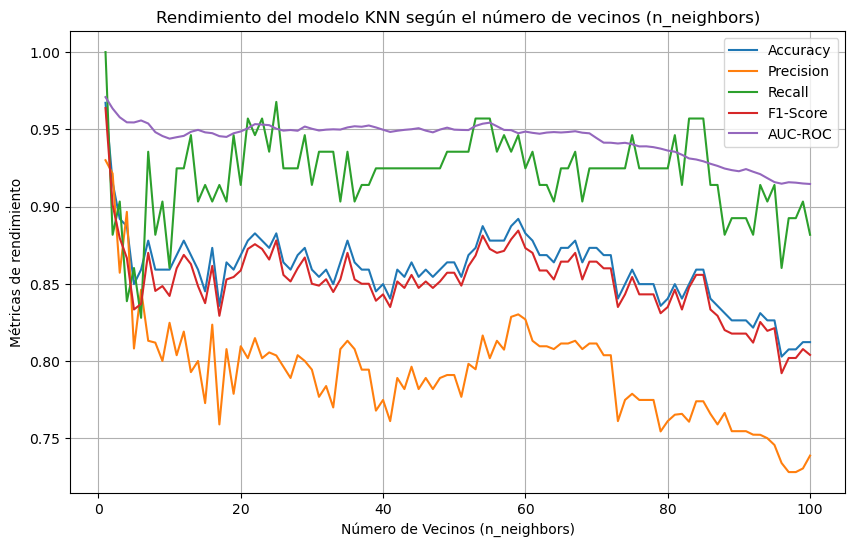

In [220]:
# 10.2.1 Entrenamiento de Modelo K-Nearest Neighbors (KNN) con n número de vecinos	
# Justificación: Utilizamos KNN como segundo modelo de clasificación, beneficiándonos de los datos balanceados por SMOTE.
print("\nEntrenando el modelo de K-Nearest Neighbors (KNN) con n número de vecinos...")

# Definir los valores de n_neighbors a evaluar
n_neighbors = range(1, 101)

# Lista para almacenar los resultados de validación y prueba de cada valor de n_neighbors
results_val_knn = []
results_test_knn = []

# Iterar sobre los valores de n_neighbors
for n in n_neighbors:
    # Crear y entrenar el modelo KNN con el valor actual de n_neighbors
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_resampled, Y_resampled)

    # Verificar el modelo en el conjunto de validación
    Y_val_pred_knn = knn.predict(X_val)
    Y_val_prob_knn = knn.predict_proba(X_val)[:, 1]

    # Calcular métricas de evaluación en el conjunto de validación
    accuracy_val = accuracy_score(Y_val, Y_val_pred_knn)
    precision_val = precision_score(Y_val, Y_val_pred_knn)
    recall_val = recall_score(Y_val, Y_val_pred_knn)
    f1_val = f1_score(Y_val, Y_val_pred_knn)
    auc_roc_val = roc_auc_score(Y_val, Y_val_prob_knn)

    # Almacenar los resultados de validación
    results_val_knn.append({
        'n_neighbors': n,
        'accuracy': accuracy_val,
        'precision': precision_val,
        'recall': recall_val,
        'f1': f1_val,
        'auc_roc': auc_roc_val
    })

# Extraer las métricas de rendimiento para cada valor de n_neighbors de los resultados de validación y prueba
n_neighbors_list = [result['n_neighbors'] for result in results_val_knn]
accuracy_list_val = [result['accuracy'] for result in results_val_knn]
precision_list_val = [result['precision'] for result in results_val_knn]
recall_list_val = [result['recall'] for result in results_val_knn]
f1_list_val = [result['f1'] for result in results_val_knn]
auc_roc_list_val = [result['auc_roc'] for result in results_val_knn]

# Mostrar los resultados de validación
print("\nResultados de validación para cada valor de n_neighbors:")
for result in results_test_knn:
    print(f"N_neighbors {result['n_neighbors']}: Accuracy = {result['accuracy']:.4f}, Precision = {result['precision']:.4f}, Recall = {result['recall']:.4f}, F1 = {result['f1']:.4f}, AUC-ROC = {result['auc_roc']:.4f}")

# Graficar los resultados en el conjunto de validación
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors_list, accuracy_list_val, label="Accuracy")
plt.plot(n_neighbors_list, precision_list_val, label="Precision")
plt.plot(n_neighbors_list, recall_list_val, label="Recall")
plt.plot(n_neighbors_list, f1_list_val, label="F1-Score")
plt.plot(n_neighbors_list, auc_roc_list_val, label="AUC-ROC")
plt.xlabel("Número de Vecinos (n_neighbors)")
plt.ylabel("Métricas de rendimiento")
plt.title("Rendimiento del modelo KNN según el número de vecinos (n_neighbors)")
plt.legend()
plt.grid(True)
plt.show()


Mejor número de vecinos en el conjunto de validación:
Accuracy: 1
Precision: 1
Recall: 1
F1-Score: 1
AUC-ROC: 1

Resultados finales para KNN con n_neighbors basado en AUC-ROC = 1:
Accuracy: 0.9720
Precision: 0.9780
Recall: 0.9570
F1-Score: 0.9674
AUC-ROC: 0.9702


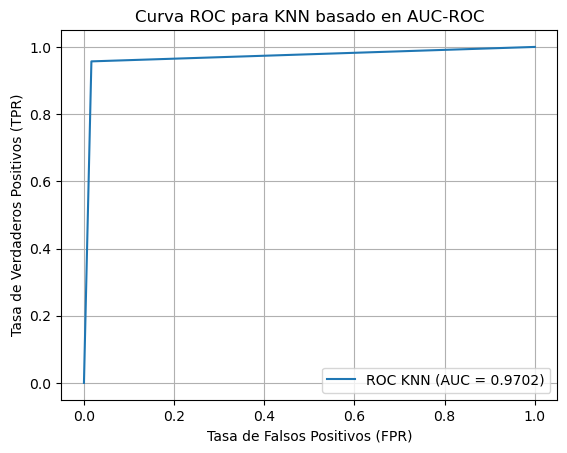

In [221]:
# Seleccionar el mejor valor de n_neighbors basado en cada métrica
# Para el conjunto de validación
best_n_accuracy_val = n_neighbors_list[np.argmax(accuracy_list_val)]
best_n_precision_val = n_neighbors_list[np.argmax(precision_list_val)]
best_n_recall_val = n_neighbors_list[np.argmax(recall_list_val)]
best_n_f1_val = n_neighbors_list[np.argmax(f1_list_val)]
best_n_auc_roc_val = n_neighbors_list[np.argmax(auc_roc_list_val)]

# Mostrar los mejores valores de n_neighbors para el conjunto de validación
print("\nMejor número de vecinos en el conjunto de validación:")
print(f"Accuracy: {best_n_accuracy_val}")
print(f"Precision: {best_n_precision_val}")
print(f"Recall: {best_n_recall_val}")
print(f"F1-Score: {best_n_f1_val}")
print(f"AUC-ROC: {best_n_auc_roc_val}")

# Entrenar y evaluar el mejor modelo basado en AUC-ROC
knn_best_auc_roc = KNeighborsClassifier(n_neighbors=best_n_auc_roc_val)
knn_best_auc_roc.fit(X_resampled, Y_resampled)
Y_test_pred_knn_auc_roc = knn_best_auc_roc.predict(X_test)
Y_test_prob_knn_auc_roc = knn_best_auc_roc.predict_proba(X_test)[:, 1]

# Evaluar el mejor modelo en el conjunto de prueba
accuracy_test_knn_auc_roc = accuracy_score(Y_test, Y_test_pred_knn_auc_roc)
precision_test_knn_auc_roc = precision_score(Y_test, Y_test_pred_knn_auc_roc)
recall_test_knn_auc_roc = recall_score(Y_test, Y_test_pred_knn_auc_roc)
f1_test_knn_auc_roc = f1_score(Y_test, Y_test_pred_knn_auc_roc)
auc_roc_test_knn_auc_roc = roc_auc_score(Y_test, Y_test_prob_knn_auc_roc)

print(f"\nResultados finales para KNN con n_neighbors basado en AUC-ROC = {best_n_auc_roc_val}:")
print(f"Accuracy: {accuracy_test_knn_auc_roc:.4f}")
print(f"Precision: {precision_test_knn_auc_roc:.4f}")
print(f"Recall: {recall_test_knn_auc_roc:.4f}")
print(f"F1-Score: {f1_test_knn_auc_roc:.4f}")
print(f"AUC-ROC: {auc_roc_test_knn_auc_roc:.4f}")

# Graficar la curva ROC para el mejor modelo basado en AUC-ROC
fpr_knn, tpr_knn, _ = roc_curve(Y_test, Y_test_prob_knn_auc_roc)
plt.plot(fpr_knn, tpr_knn, label=f'ROC KNN (AUC = {auc_roc_test_knn_auc_roc:.4f})')

plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para KNN basado en AUC-ROC')
plt.legend()
plt.grid(True)
plt.show()

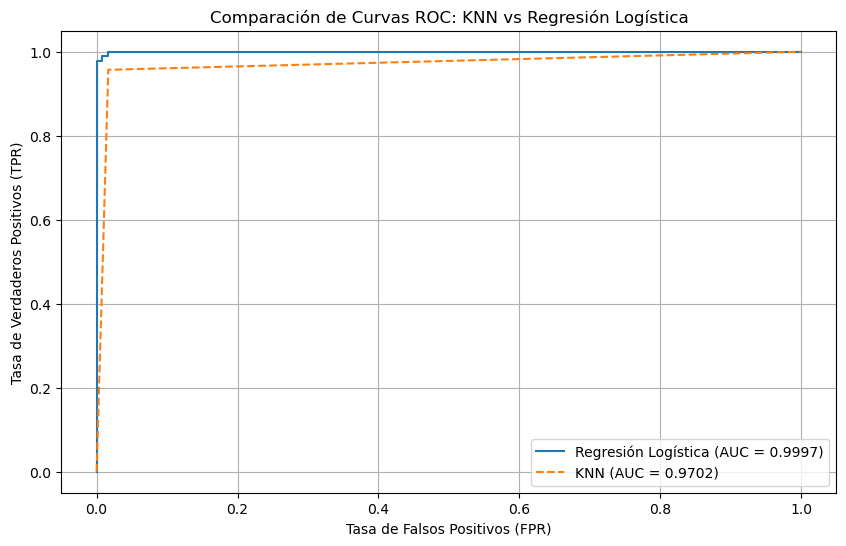

In [223]:
# Entrenamos el modelo de Regresión Logística (ya debe estar previamente entrenado)
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_resampled, Y_resampled)

# Predicciones y probabilidades para Regresión Logística en el conjunto de prueba
Y_test_prob_logreg = log_reg.predict_proba(X_test)[:, 1]

# Curva ROC para Regresión Logística
fpr_logreg, tpr_logreg, _ = roc_curve(Y_test, Y_test_prob_logreg)
auc_roc_logreg = roc_auc_score(Y_test, Y_test_prob_logreg)

# Entrenamos el mejor modelo KNN (usamos el que tiene mejor AUC-ROC, previamente seleccionado)
knn_best_auc_roc = KNeighborsClassifier(n_neighbors=best_n_auc_roc_val)
knn_best_auc_roc.fit(X_resampled, Y_resampled)

# Predicciones y probabilidades para KNN en el conjunto de prueba
Y_test_prob_knn_auc_roc = knn_best_auc_roc.predict_proba(X_test)[:, 1]

# Curva ROC para KNN
fpr_knn, tpr_knn, _ = roc_curve(Y_test, Y_test_prob_knn_auc_roc)
auc_roc_knn = roc_auc_score(Y_test, Y_test_prob_knn_auc_roc)

# Graficamos ambas curvas ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Regresión Logística (AUC = {auc_roc_logreg:.4f})', linestyle='-')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_roc_knn:.4f})', linestyle='--')

# Etiquetas y leyenda
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparación de Curvas ROC: KNN vs Regresión Logística')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()